In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
 
from datetime import datetime,timedelta
import datetime as dt
from sklearn.metrics import classification_report


In [2]:
# DATA Collection

urls = ['https://raw.githubusercontent.com/GuillaumeRouja/2021-Tennis_Bet/main/Data/2010.csv','https://raw.githubusercontent.com/GuillaumeRouja/2021-Tennis_Bet/main/Data/2011.csv',
        'https://raw.githubusercontent.com/GuillaumeRouja/2021-Tennis_Bet/main/Data/2012.csv','https://raw.githubusercontent.com/GuillaumeRouja/2021-Tennis_Bet/main/Data/2013.csv',
        'https://raw.githubusercontent.com/GuillaumeRouja/2021-Tennis_Bet/main/Data/2014.csv','https://raw.githubusercontent.com/GuillaumeRouja/2021-Tennis_Bet/main/Data/2015.csv',
        'https://raw.githubusercontent.com/GuillaumeRouja/2021-Tennis_Bet/main/Data/2016.csv','https://raw.githubusercontent.com/GuillaumeRouja/2021-Tennis_Bet/main/Data/2017.csv',
        'https://raw.githubusercontent.com/GuillaumeRouja/2021-Tennis_Bet/main/Data/2018.csv','https://raw.githubusercontent.com/GuillaumeRouja/2021-Tennis_Bet/main/Data/2019.csv',
        'https://raw.githubusercontent.com/GuillaumeRouja/2021-Tennis_Bet/main/Data/2020.csv','https://raw.githubusercontent.com/GuillaumeRouja/2021-Tennis_Bet/main/Data/2021.csv']

dfs = [pd.read_csv(url,sep=';') for url in urls]
data = pd.concat(dfs, ignore_index=True)

# Keep colums we need -> Only keep data known at game time 

data.drop(['WPts','LPts','W1','L1','W2','L2','W3','L3','W4','L4','W5','L5','Wsets','Lsets','EXW','EXL','LBW','LBL','SJW','SJL','MaxW','MaxL','AvgW','AvgL'],axis=1,inplace=True)

#Format adjustment

data.PSW= (data.PSW.replace(',','.', regex=True).astype(float))
data.PSL= (data.PSL.replace(',','.', regex=True).astype(float))
data.B365W= (data.B365W.replace(',','.', regex=True).astype(float))
data.B365L= (data.B365L.replace(',','.', regex=True).astype(float)) 

data['Date'] = pd.to_datetime(data.Date,dayfirst=True)

data.sort_values(['Date'], inplace=True)
data=data.reset_index(drop=True)


In [3]:
data.head(3)

,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,Loser,WRank,LRank,Comment,B365W,B365L,PSW,PSL
0,1,Brisbane,Brisbane International,2010-01-04,ATP250,Outdoor,Hard,1st Round,3,Gasquet R.,Nieminen J.,52.0,88.0,Completed,1.44,2.62,1.526,2.740
1,3,Doha,Qatar Exxon Mobil Open,2010-01-04,ATP250,Outdoor,Hard,1st Round,3,Gulbis E.,Montanes A.,90.0,31.0,Completed,1.40,2.75,1.426,3.140
2,3,Doha,Qatar Exxon Mobil Open,2010-01-04,ATP250,Outdoor,Hard,1st Round,3,Starace P.,Gil F.,62.0,69.0,Completed,2.25,1.57,2.550,1.595


## **Data Pre-processing**

#### Timeframe selection

In [4]:
# Given there are some duplicated lines in 2012 and data stop between 2013-11-11 to 2014-01-05, we'll start the analysis from 2015.

# Data selection

beg=datetime(2015,1,1) 
end=datetime(2021,12,31)

indices=data[(data.Date>beg)&(data.Date<=end)].index
data=data.iloc[indices,:]

print("Number of games since Jan'2015: ",len(data))

data.sort_values(['Date'], inplace=True)
data=data.reset_index(drop=True)


Number of games since Jan'2015:  16588


#### ELO Ranking Computing

In [5]:
def compute_elo_rankings(data):
    """
    Given the list of matches in chronological order, for each match, computes 
    the elo ranking of the 2 players at the beginning of the match
    
    """
    print("Elo rankings computing...")
    players=list(pd.Series(list(data.Winner)+list(data.Loser)).value_counts().index) # Gather all players from data
    elo=pd.Series(np.ones(len(players))*1500,index=players) # Attribute Elo Ranking of 1500 to each player
    ranking_elo=[(1500,1500)]
    for i in range(1,len(data)):
        w=data.iloc[i-1,:].Winner   # Select Winner and Loser of the previous game
        l=data.iloc[i-1,:].Loser
        elow=elo[w]  
        elol=elo[l]
        pwin=1 / (1 + 10 ** ((elol - elow) / 400))  # Win prob resulting from elo. Ex: elol = 1900, elow = 2000. Delta = 100 -> winner prob = 64%
        K_win=32
        K_los=32
        new_elow=elow+K_win*(1-pwin) # The winner has his elo increased by K_win*(1-pwin). Ex: 1500 + 32*(1-0.64) = 1511.52. 
        new_elol=elol-K_los*(1-pwin) # A victory against a better ranked player grants more points.
        elo[w]=new_elow
        elo[l]=new_elol
        ranking_elo.append((elo[data.iloc[i,:].Winner],elo[data.iloc[i,:].Loser])) 
        if i%3000==0:
            print(str(i)+" matches computed...")
    ranking_elo=pd.DataFrame(ranking_elo,columns=["elo_winner","elo_loser"]) 
    ranking_elo["p_elo_winner"]=1 / (1 + 10 ** ((ranking_elo["elo_loser"] - ranking_elo["elo_winner"]) / 400))   
    ranking_elo["p_elo_loser"]=1 / (1 + 10 ** ((ranking_elo["elo_winner"] - ranking_elo["elo_loser"]) / 400))
    return ranking_elo

# Computing of the elo ranking of each player at the beginning of each match.
elo_rankings = compute_elo_rankings(data)
data = pd.concat([data,elo_rankings],1)


Elo rankings computing...
3000 matches computed...
6000 matches computed...
9000 matches computed...
12000 matches computed...
15000 matches computed...


In [6]:
# Check elo ranking computing

data[(data.Winner=='Federer R.')|(data.Loser=='Federer R.')].head(7)

,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,Loser,WRank,LRank,Comment,B365W,B365L,PSW,PSL,elo_winner,elo_loser,p_elo_winner,p_elo_loser
60,1,Brisbane,Brisbane International,2015-01-08,ATP250,Outdoor,Hard,2nd Round,3,Federer R.,Millman J.,2.0,153.0,Completed,1.06,10.00,1.07,10.25,1500.000000,1516.000000,0.476990,0.523010
72,1,Brisbane,Brisbane International,2015-01-09,ATP250,Outdoor,Hard,Quarterfinals,3,Federer R.,Duckworth J.,2.0,125.0,Completed,1.05,11.00,1.06,13.40,1516.736307,1532.000000,0.478048,0.521952
79,1,Brisbane,Brisbane International,2015-01-10,ATP250,Outdoor,Hard,Semifinals,3,Federer R.,Dimitrov G.,2.0,11.0,Completed,1.28,3.75,1.32,3.79,1533.438774,1533.438774,0.500000,0.500000
84,1,Brisbane,Brisbane International,2015-01-11,ATP250,Outdoor,Hard,The Final,3,Federer R.,Raonic M.,2.0,8.0,Completed,1.25,4.00,1.30,3.97,1549.438774,1549.438774,0.500000,0.500000
158,6,Melbourne,Australian Open,2015-01-19,Grand Slam,Outdoor,Hard,1st Round,5,Federer R.,Lu Y.H.,2.0,47.0,Completed,1.02,17.00,1.03,20.00,1565.438774,1513.188319,0.574633,0.425367
212,6,Melbourne,Australian Open,2015-01-21,Grand Slam,Outdoor,Hard,2nd Round,5,Federer R.,Bolelli S.,2.0,48.0,Completed,1.02,17.00,1.03,18.00,1579.050529,1529.287716,0.571129,0.428871
237,6,Melbourne,Australian Open,2015-01-23,Grand Slam,Outdoor,Hard,3rd Round,5,Seppi A.,Federer R.,46.0,2.0,Completed,17.00,1.02,23.50,1.02,1543.793749,1592.774410,0.429974,0.570026


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16588 entries, 0 to 16587
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   ATP           16588 non-null  int64         
 1   Location      16588 non-null  object        
 2   Tournament    16588 non-null  object        
 3   Date          16588 non-null  datetime64[ns]
 4   Series        16588 non-null  object        
 5   Court         16588 non-null  object        
 6   Surface       16588 non-null  object        
 7   Round         16588 non-null  object        
 8   Best of       16588 non-null  int64         
 9   Winner        16588 non-null  object        
 10  Loser         16588 non-null  object        
 11  WRank         16579 non-null  float64       
 12  LRank         16544 non-null  float64       
 13  Comment       16588 non-null  object        
 14  B365W         16533 non-null  float64       
 15  B365L         16534 non-null  float6

#### Remove outliers and absurd values

In [8]:
# Only use normal completed games

data = data[data.Comment == 'Completed']
data.drop('Comment',axis=1,inplace=True)

# Remove Round Robin tournaments as they interfere with some cumulative stats calculations

data = data[data.Round != 'Round Robin']

# Odds need to be > 1

data = data[(data.PSW >1)&(data.PSL>1)&(data.B365W>1)&(data.B365W>1)]

# ATP rankings cannot be 0

data = data[(data.WRank != 0) & (data.LRank != 0)]

# Remove remaining NaNs

data.dropna(axis=0,inplace=True)


#### Create cumulative stats 



In [9]:
# Player dataset preparation

# Step 1 -> Copy Data and add a counter for victorie and defeats

data.reset_index(inplace=True)

df1 = data.copy()
df1['w']=1
df1['l']=0

# step 2 -> Select and concatenate the columns we need

index=df1['index']
winner=df1['Winner']
loser=df1['Loser']
surface=df1['Surface']
w=df1['w']
l=df1['l']
date=df1['Date']

df2 = pd.concat([index,winner,loser,surface,w,l,date], axis = 1)

# step 3 -> Create Player dataframe : create a row for each player (double nb of lines)

player=pd.concat([winner,loser], axis = 0)
status=pd.concat([w,l], axis = 0)
index=pd.concat([index,index], axis = 0)
surface=pd.concat([surface,surface], axis = 0)
date=pd.concat([date,date], axis = 0)

df3 = pd.concat([index,player, status,surface,date], axis = 1)
df3.columns = ['index','Player','Winner','Surface','Date']

df3.info()
print(df3.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31622 entries, 0 to 15810
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   index    31622 non-null  int64         
 1   Player   31622 non-null  object        
 2   Winner   31622 non-null  int64         
 3   Surface  31622 non-null  object        
 4   Date     31622 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 1.4+ MB
0


In [10]:
# step 4 -> Pivot table 

df_players = pd.pivot_table(df3,index=['Player','index','Surface','Date'])

# step 5 -> Build Defeats counter where winner = 0.

df_players['Loser']=df_players['Winner'].apply(lambda x: 0 if x ==1 else 1)

# step 6 -> Sort Players Dataframe by Date (preparation for cumulative variables)

df_players.reset_index(inplace=True)
df_players.set_index(['Date'], inplace=True)
df_players.sort_values(['Date'], inplace=True)

df_players.head()

,Player,index,Surface,Winner,Loser
Date,,,,,
2015-01-05,Verdasco F.,5,Hard,1,0
2015-01-05,Dodig I.,11,Hard,1,0
2015-01-05,Gasquet R.,12,Hard,1,0
2015-01-05,Golubev A.,1,Hard,0,1
2015-01-05,Querrey S.,6,Hard,0,1


In [11]:
# Step 7 : Build cumlative stats

df_surface = df_players.copy()

# step 7a -> Cumulative wins/defeats (Rolling sum on recent days removing game of the day because result still unknown)

df_players['Wins_R']=df_players.groupby('Player')['Winner'].transform(lambda x: x.rolling('3000D').sum()).fillna(0)-df_players['Winner']  # NB days can be changed if needed
df_players['Defeats_R']=df_players.groupby('Player')['Loser'].transform(lambda x: x.rolling('3000D').sum()).fillna(0)-df_players['Loser'] # NB days can be changed if needed
df_players['Played_R']=df_players['Wins_R']+df_players['Defeats_R']
df_players['WinRate_R']=df_players['Wins_R']/df_players['Played_R']
df_players['WinRate_R'].fillna(0,inplace=True)

# # step 7b -> Cumulative wins/defeats by surface

print(df_surface.Surface.value_counts())

df_surface['Wins_R']=df_surface.groupby(['Player','Surface'])['Winner'].transform(lambda x: x.rolling('3000D').sum()).fillna(0)-df_surface['Winner']  # NB days can be changed if needed
df_surface['Defeats_R']=df_surface.groupby(['Player','Surface'])['Loser'].transform(lambda x: x.rolling('3000D').sum()).fillna(0)-df_surface['Loser'] # NB days can be changed if needed
df_surface['Played_R']=df_surface['Wins_R']+df_surface['Defeats_R']
df_surface['WinRate_R']=df_surface['Wins_R']/df_surface['Played_R']
df_surface['WinRate_R'].fillna(0,inplace=True)

Hard     18036
Clay      9912
Grass     3674
Name: Surface, dtype: int64


In [12]:
# check

df_surface[(df_players.Player=='Federer R.')|(df_players.Player=='Federer R.')].head()

,Player,index,Surface,Winner,Loser,Wins_R,Defeats_R,Played_R,WinRate_R
Date,,,,,,,,,
2015-01-08,Federer R.,60,Hard,1,0,0,0,0,0.0
2015-01-09,Federer R.,72,Hard,1,0,1,0,1,1.0
2015-01-10,Federer R.,79,Hard,1,0,2,0,2,1.0
2015-01-11,Federer R.,84,Hard,1,0,3,0,3,1.0
2015-01-19,Federer R.,158,Hard,1,0,4,0,4,1.0


In [13]:
# step 8 Prepare'df_players' and 'df_surface' for merge with Data

# A. Sort Dataframe (same as Data)

df_players.sort_values(['index','Loser'], inplace=True)
df_surface.sort_values(['index','Loser'], inplace=True)

# B. Take every other line of df_Players/df_Surface to reduce the dataframe by half // Data

Players_merge = pd.DataFrame({'Winner':df_players['Player'].iloc[::2].values, 'Loser':df_players['Player'].iloc[1::2].values,
                        'Winner_wins_R':df_players['Wins_R'].iloc[::2].values, 'Loser_wins_R':df_players['Wins_R'].iloc[1::2].values,
                        'Winner_defeats_R':df_players['Defeats_R'].iloc[::2].values, 'Loser_defeats_R':df_players['Defeats_R'].iloc[1::2].values,
                        'Winner_Played_R':df_players['Played_R'].iloc[::2].values, 'Loser_Played_R':df_players['Played_R'].iloc[1::2].values,
                        'Winner_WinRate_R':df_players['WinRate_R'].iloc[::2].values, 'Loser_WinRate_R':df_players['WinRate_R'].iloc[1::2].values,
                        'Winner_wins_S':df_surface['Wins_R'].iloc[::2].values, 'Loser_wins_S':df_surface['Wins_R'].iloc[1::2].values,
                        'Winner_defeats_S':df_surface['Defeats_R'].iloc[::2].values, 'Loser_defeats_S':df_surface['Defeats_R'].iloc[1::2].values,
                        'Winner_Played_S':df_surface['Played_R'].iloc[::2].values, 'Loser_Played_S':df_surface['Played_R'].iloc[1::2].values,
                        'Winner_WinRate_S':df_surface['WinRate_R'].iloc[::2].values, 'Loser_WinRate_S':df_surface['WinRate_R'].iloc[1::2].values,
                        'index':df_players['index'].iloc[1::2].values})

# step 9 -> Merging Data with Players on: index, Loser, Winner 

Players_merge.rename(columns={'index': 'index_t', 'Winner': 'Winner_t', 'Loser': 'Loser_t'},inplace=True)
data=pd.concat([data,Players_merge], axis = 1)
data.drop(['index_t','Winner_t','Loser_t'],axis=1,inplace=True)

In [14]:
#Check

data[(data.Winner=='Federer R.')|(data.Loser=='Federer R.')].head()

,index,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,Loser,WRank,LRank,B365W,B365L,PSW,PSL,elo_winner,elo_loser,p_elo_winner,p_elo_loser,Winner_wins_R,Loser_wins_R,Winner_defeats_R,Loser_defeats_R,Winner_Played_R,Loser_Played_R,Winner_WinRate_R,Loser_WinRate_R,Winner_wins_S,Loser_wins_S,Winner_defeats_S,Loser_defeats_S,Winner_Played_S,Loser_Played_S,Winner_WinRate_S,Loser_WinRate_S
58,60,1,Brisbane,Brisbane International,2015-01-08,ATP250,Outdoor,Hard,2nd Round,3,Federer R.,Millman J.,2.0,153.0,1.06,10.00,1.07,10.25,1500.000000,1516.000000,0.476990,0.523010,0,1,0,0,0,1,0.0,1.0,0,1,0,0,0,1,0.0,1.0
70,72,1,Brisbane,Brisbane International,2015-01-09,ATP250,Outdoor,Hard,Quarterfinals,3,Federer R.,Duckworth J.,2.0,125.0,1.05,11.00,1.06,13.40,1516.736307,1532.000000,0.478048,0.521952,1,2,0,0,1,2,1.0,1.0,1,2,0,0,1,2,1.0,1.0
77,79,1,Brisbane,Brisbane International,2015-01-10,ATP250,Outdoor,Hard,Semifinals,3,Federer R.,Dimitrov G.,2.0,11.0,1.28,3.75,1.32,3.79,1533.438774,1533.438774,0.500000,0.500000,2,2,0,0,2,2,1.0,1.0,2,2,0,0,2,2,1.0,1.0
82,84,1,Brisbane,Brisbane International,2015-01-11,ATP250,Outdoor,Hard,The Final,3,Federer R.,Raonic M.,2.0,8.0,1.25,4.00,1.30,3.97,1549.438774,1549.438774,0.500000,0.500000,3,3,0,0,3,3,1.0,1.0,3,3,0,0,3,3,1.0,1.0
155,158,6,Melbourne,Australian Open,2015-01-19,Grand Slam,Outdoor,Hard,1st Round,5,Federer R.,Lu Y.H.,2.0,47.0,1.02,17.00,1.03,20.00,1565.438774,1513.188319,0.574633,0.425367,4,3,0,2,4,5,1.0,0.6,4,3,0,2,4,5,1.0,0.6


#### Remove Winners / Losers -> Replace with P1 and P2 taken randomly 

In [15]:
# Values of Player 1 and 2 are taken randomly

# First we create Player 1

v = data[['Winner', 'Loser']].values
ix = np.random.randint(0,v.shape[1],data.shape[0])
data['P1'] = np.take_along_axis(v, ix[:,None], 1)

# Then Player 2 

data['P2'] = np.where(data.P1 == data.Winner,data.Loser, data.Winner)

# We then allocate all the attributes by checking the position of P1/P2 vs Winner/Loser on each line:

data['P1_Rank']=np.where(data.P1 == data.Winner,data.WRank,data.LRank)
data['P2_Rank']=np.where(data.P2 == data.Winner,data.WRank,data.LRank)

data['P1_Elo']=np.where(data.P1 == data.Winner,data.elo_winner,data.elo_loser)
data['P2_Elo']=np.where(data.P2 == data.Winner,data.elo_winner,data.elo_loser)

data['P1_p_Elo']=np.where(data.P1 == data.Winner,data.p_elo_winner,data.p_elo_loser)
data['P2_p_Elo']=np.where(data.P2 == data.Winner,data.p_elo_winner,data.p_elo_loser)

data['P1_Odds_Pin']=np.where(data.P1 == data.Winner,data.PSW,data.PSL)
data['P2_Odds_Pin']=np.where(data.P2 == data.Winner,data.PSW,data.PSL)

data['P1_Odds_B365']=np.where(data.P1 == data.Winner,data.B365W,data.B365L)
data['P2_Odds_B365']=np.where(data.P2 == data.Winner,data.B365W,data.B365L)

data['P1_Wins']=np.where(data.P1 == data.Winner,data.Winner_wins_R,data.Loser_wins_R)
data['P2_Wins']=np.where(data.P2 == data.Winner,data.Winner_wins_R,data.Loser_wins_R)

data['P1_Defeats']=np.where(data.P1 == data.Winner,data.Winner_defeats_R,data.Loser_defeats_R)
data['P2_Defeats']=np.where(data.P2 == data.Winner,data.Winner_defeats_R,data.Loser_defeats_R)

data['P1_Played']=np.where(data.P1 == data.Winner,data.Winner_Played_R,data.Loser_Played_R)
data['P2_Played']=np.where(data.P2 == data.Winner,data.Winner_Played_R,data.Loser_Played_R)

data['P1_WinRate']=np.where(data.P1 == data.Winner,data.Winner_WinRate_R,data.Loser_WinRate_R)
data['P2_WinRate']=np.where(data.P2 == data.Winner,data.Winner_WinRate_R,data.Loser_WinRate_R)

data['P1_Surface_Wins']=np.where(data.P1 == data.Winner,data.Winner_wins_S,data.Loser_wins_S)
data['P2_Surface_Wins']=np.where(data.P2 == data.Winner,data.Winner_wins_S,data.Loser_wins_S)

data['P1_Surface_Defeats']=np.where(data.P1 == data.Winner,data.Winner_defeats_S,data.Loser_defeats_S)
data['P2_Surface_Defeats']=np.where(data.P2 == data.Winner,data.Winner_defeats_S,data.Loser_defeats_S)

data['P1_Surface_Played']=np.where(data.P1 == data.Winner,data.Winner_Played_S,data.Loser_Played_S)
data['P2_Surface_Played']=np.where(data.P2 == data.Winner,data.Winner_Played_S,data.Loser_Played_S)

data['P1_Surface_WinRate']=np.where(data.P1 == data.Winner,data.Winner_WinRate_S,data.Loser_WinRate_S)
data['P2_Surface_WinRate']=np.where(data.P2 == data.Winner,data.Winner_WinRate_S,data.Loser_WinRate_S)




#### Target variable preparation

In [16]:
# Code '1' if player 1 wins, '2' if player 2 wins -> classification task

data['Won']=np.where(data.P1 == data.Winner,1,2)


In [17]:
# Next, we remove the columns we don't need

data.drop(['WRank','LRank','PSL','PSW','B365W','B365L','elo_winner','elo_loser','p_elo_winner','p_elo_loser','Loser','Winner',
           'Winner_wins_R','Loser_wins_R','Winner_defeats_R','Loser_defeats_R','Winner_Played_R','Loser_Played_R','Winner_WinRate_R','Loser_WinRate_R',
           'Winner_wins_S','Loser_wins_S','Winner_defeats_S','Loser_defeats_S','Winner_Played_S','Loser_Played_S','Winner_WinRate_S','Loser_WinRate_S'],axis=1,inplace=True) 


In [18]:
# Reorder Columns -> Winner at the end

cols = list(data.columns.values) # Make a list of all of the columns in the df
cols.pop(cols.index('Won')) # Remove 'Winner' from list
data = data[cols+['Won']] # change dataframe with Winner at the end

# Adjusting Columns width

pd.set_option('max_colwidth', 13)

In [19]:
# Checks - Gasquet

data[(data.P1=='Gasquet R.')|(data.P2=='Gasquet R.')].head(7)


,index,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,P1,P2,P1_Rank,P2_Rank,P1_Elo,P2_Elo,P1_p_Elo,P2_p_Elo,P1_Odds_Pin,P2_Odds_Pin,P1_Odds_B365,P2_Odds_B365,P1_Wins,P2_Wins,P1_Defeats,P2_Defeats,P1_Played,P2_Played,P1_WinRate,P2_WinRate,P1_Surface_Wins,P2_Surface_Wins,P1_Surface_Defeats,P2_Surface_Defeats,P1_Surface_Played,P2_Surface_Played,P1_Surface_WinRate,P2_Surface_WinRate,Won
11,12,3,Doha,Qatar Exx...,2015-01-05,ATP250,Outdoor,Hard,1st Round,3,Andujar P.,Gasquet R.,41.0,26.0,1500.000000,1500.000000,0.500000,0.500000,4.44,1.24,4.33,1.20,0,0,0,0,0,0,0.000000,0.00,0,0,0,0,0,0,0.000000,0.00,2
45,47,3,Doha,Qatar Exx...,2015-01-07,ATP250,Outdoor,Hard,2nd Round,3,Gasquet R.,Bolelli S.,26.0,52.0,1516.000000,1516.000000,0.500000,0.500000,1.28,4.14,1.25,3.75,1,1,0,0,1,1,1.000000,1.00,1,1,0,0,1,1,1.000000,1.00,1
65,67,3,Doha,Qatar Exx...,2015-01-08,ATP250,Outdoor,Hard,Quarterfi...,3,Gasquet R.,Berdych T.,26.0,7.0,1532.000000,1532.000000,0.500000,0.500000,3.12,1.43,2.75,1.40,2,2,0,0,2,2,1.000000,1.00,2,2,0,0,2,2,1.000000,1.00,2
143,146,6,Melbourne,Australia...,2015-01-19,Grand Slam,Outdoor,Hard,1st Round,5,Gasquet R.,Berlocq C.,28.0,70.0,1516.000000,1484.000000,0.545922,0.454078,1.08,10.15,1.08,8.00,2,0,1,1,3,1,0.666667,0.00,2,0,1,1,3,1,0.666667,0.00,1
202,209,6,Melbourne,Australia...,2015-01-21,Grand Slam,Outdoor,Hard,2nd Round,5,Gasquet R.,Duckworth J.,28.0,120.0,1530.530498,1530.593510,0.499909,0.500091,1.13,7.04,1.07,9.00,3,3,1,1,4,4,0.750000,0.75,3,3,1,1,4,4,0.750000,0.75,1
231,239,6,Melbourne,Australia...,2015-01-23,Grand Slam,Outdoor,Hard,3rd Round,5,Anderson K.,Gasquet R.,15.0,28.0,1535.680117,1546.533400,0.484386,0.515614,2.56,1.59,2.50,1.50,4,4,2,1,6,5,0.666667,0.80,4,4,2,1,6,5,0.666667,0.80,1
289,297,7,Montpellier,Open Sud ...,2015-02-04,ATP250,Indoor,Hard,2nd Round,3,Gasquet R.,Pouille L.,28.0,115.0,1530.033751,1516.360103,0.519668,0.480332,1.21,5.02,1.18,4.50,4,3,2,2,6,5,0.666667,0.60,4,3,2,2,6,5,0.666667,0.60,1


In [20]:
# Additional variables for data analysis

data['Year']=data.Date.dt.year
data['Month']=data.Date.dt.month

In [21]:
data.tail()

,index,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,P1,P2,P1_Rank,P2_Rank,P1_Elo,P2_Elo,P1_p_Elo,P2_p_Elo,P1_Odds_Pin,P2_Odds_Pin,P1_Odds_B365,P2_Odds_B365,P1_Wins,P2_Wins,P1_Defeats,P2_Defeats,P1_Played,P2_Played,P1_WinRate,P2_WinRate,P1_Surface_Wins,P2_Surface_Wins,P1_Surface_Defeats,P2_Surface_Defeats,P1_Surface_Played,P2_Surface_Played,P1_Surface_WinRate,P2_Surface_WinRate,Won,Year,Month
15806,16582,52,San Diego,San Diego...,2021-10-02,ATP250,Outdoor,Hard,Quarterfi...,3,Dimitrov G.,Karatsev A.,29.0,24.0,1679.210996,1681.356858,0.496912,0.503088,2.22,1.74,2.20,1.66,186,29,127,20,313,49,0.594249,0.591837,139,19,82,12,221,31,0.628959,0.612903,1,2021,10
15807,16583,52,San Diego,San Diego...,2021-10-02,ATP250,Outdoor,Hard,Quarterfi...,3,Ruud C.,Sonego L.,10.0,23.0,1828.262965,1704.454276,0.670998,0.329002,1.51,2.75,1.53,2.50,85,63,55,62,140,125,0.607143,0.504000,15,26,24,29,39,55,0.384615,0.472727,1,2021,10
15808,16584,53,Sofia,Sofia Open,2021-10-02,ATP250,Indoor,Hard,Semifinals,3,Sinner J.,Krajinovi...,14.0,37.0,1786.911944,1619.182711,0.724227,0.275773,1.43,3.07,1.40,3.00,60,81,36,75,96,156,0.625000,0.519231,41,59,20,51,61,110,0.672131,0.536364,1,2021,10
15809,16585,53,Sofia,Sofia Open,2021-10-03,ATP250,Indoor,Hard,The Final,3,Monfils G.,Sinner J.,20.0,14.0,1714.065497,1795.736678,0.384584,0.615416,2.31,1.69,2.37,1.57,185,61,93,36,278,97,0.665468,0.628866,129,42,47,20,176,62,0.732955,0.677419,2,2021,10
15810,16586,52,San Diego,San Diego...,2021-10-03,ATP250,Outdoor,Hard,Semifinals,3,Dimitrov G.,Ruud C.,29.0,10.0,1695.309815,1838.791045,0.304503,0.695497,2.97,1.45,2.75,1.44,187,86,127,55,314,141,0.595541,0.609929,140,16,82,24,222,40,0.630631,0.400000,2,2021,10


In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15811 entries, 0 to 15810
Data columns (total 41 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   index               15811 non-null  int64         
 1   ATP                 15811 non-null  int64         
 2   Location            15811 non-null  object        
 3   Tournament          15811 non-null  object        
 4   Date                15811 non-null  datetime64[ns]
 5   Series              15811 non-null  object        
 6   Court               15811 non-null  object        
 7   Surface             15811 non-null  object        
 8   Round               15811 non-null  object        
 9   Best of             15811 non-null  int64         
 10  P1                  15811 non-null  object        
 11  P2                  15811 non-null  object        
 12  P1_Rank             15811 non-null  float64       
 13  P2_Rank             15811 non-null  float64   

In [23]:

# Features selection

data=data[['P1_Surface_WinRate','P2_Surface_WinRate','P1_p_Elo','P2_p_Elo','P1_Rank','P2_Rank','Won']].copy()




We found the above parameters are the most efficient to build the strongest model. Adding more parameters may provide a marginally higher accuracy at the expense of an increased overfitting.

NB: Including the bookmaker's odds does provide an increased accuracy, however the model will almost exclusively rely on this feature which will not be efficient in order to achieve a positive ROI since we will only mimic (and do slightly worse) the bookmaker's prediction.

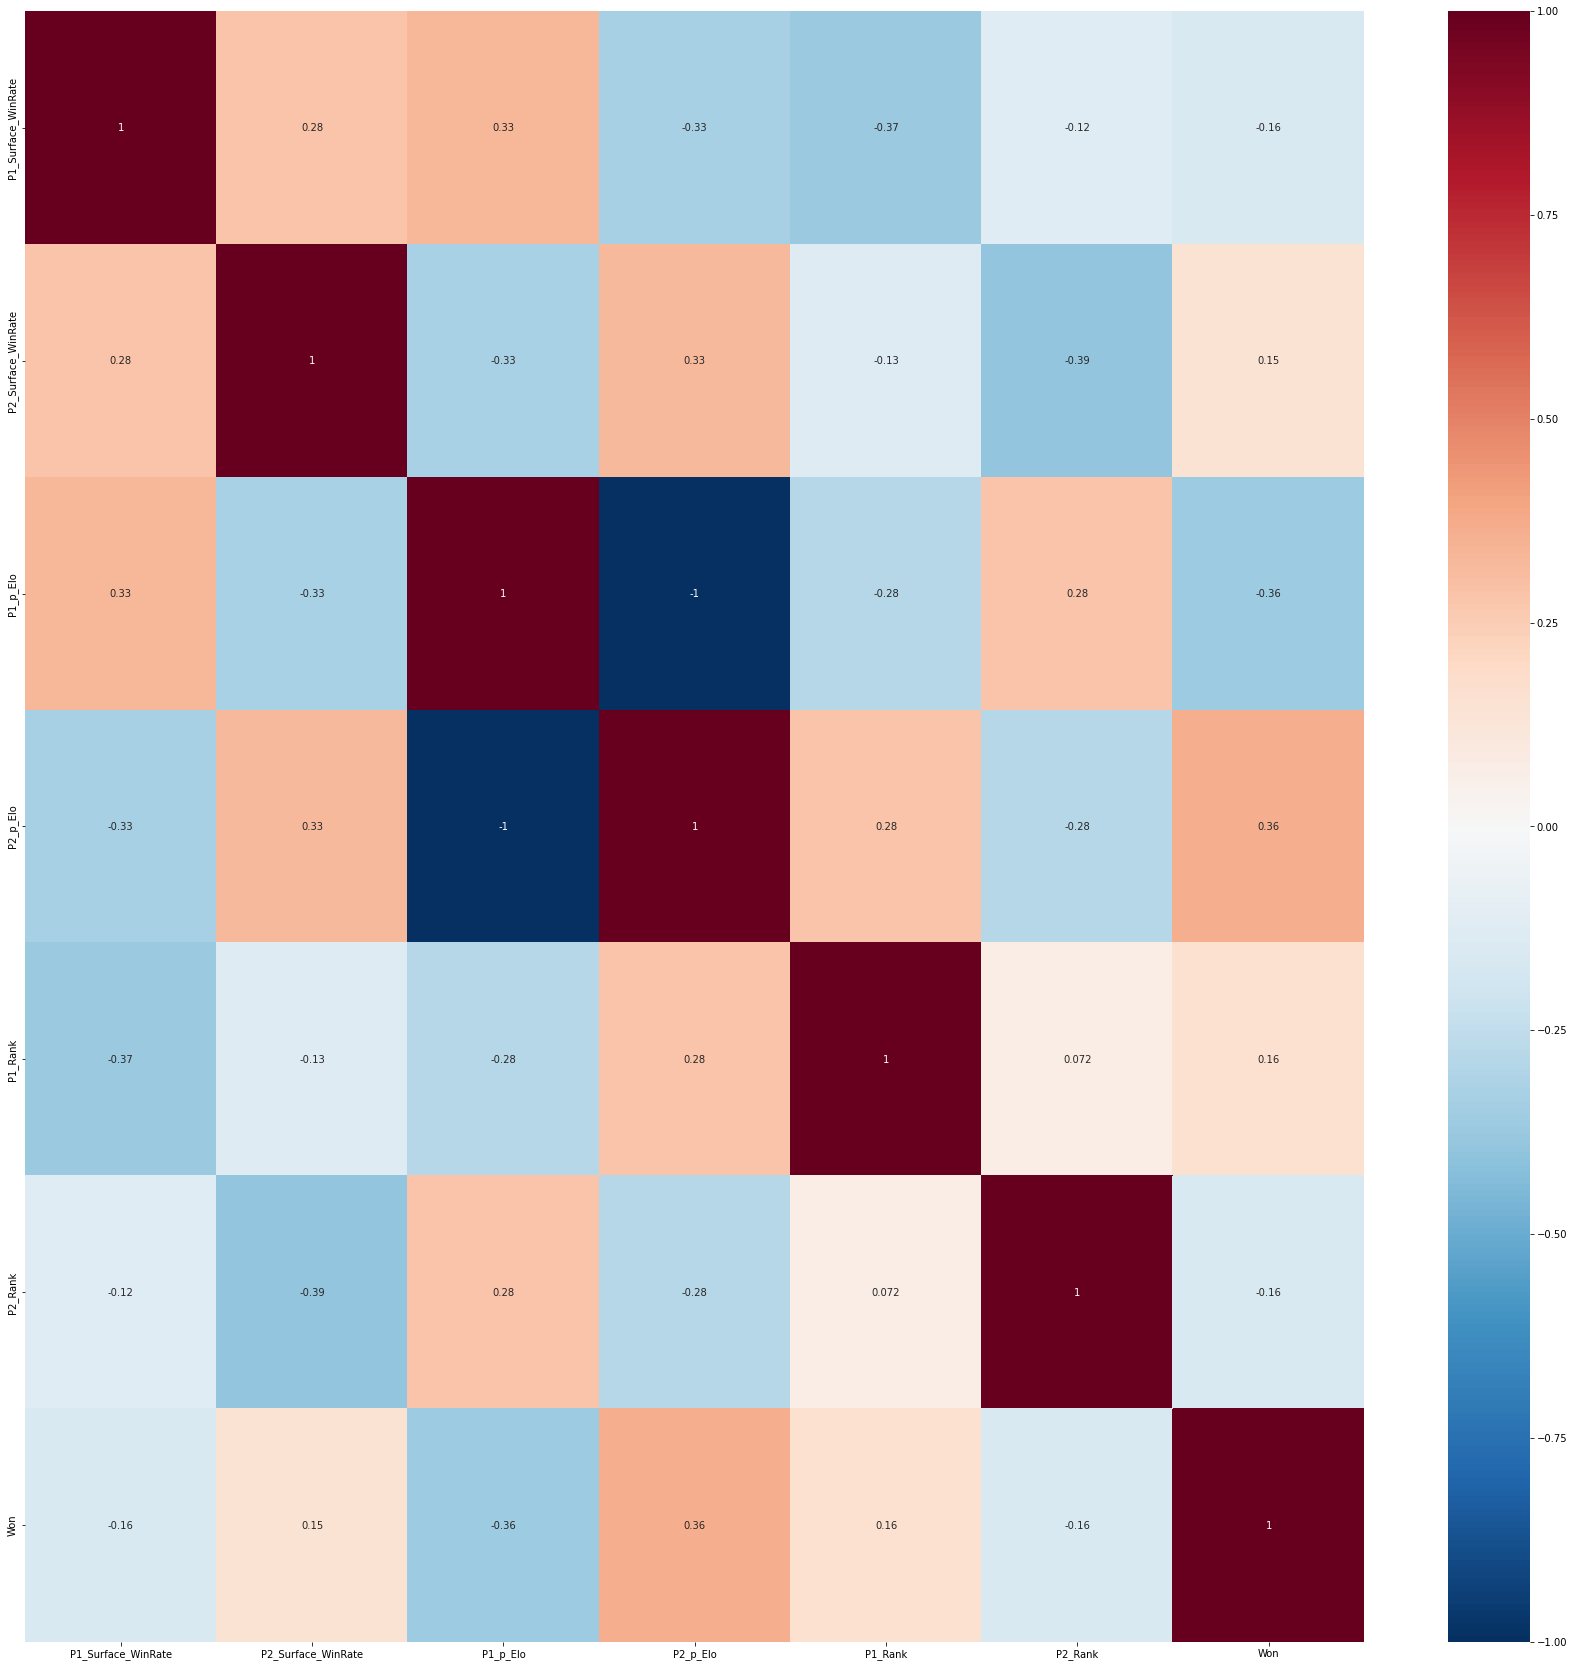

In [24]:
# Heatmap 

plt.figure(figsize=(30,30))
correlation = data.corr()
sns.heatmap(correlation,  annot=True, cmap="RdBu_r", center =0);
plt.show()

#### Data Split and normalization

In [25]:
# Split data and target 

DATA = data.drop('Won',axis=1)
TARGET = data['Won']

In [26]:
# Split train/test

from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(DATA,TARGET,test_size=0.2,random_state=10)

In [27]:
# Normalization

#from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer

qt = QuantileTransformer(random_state=0)
scaler=qt.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test = scaler.transform(X_test)

#from sklearn import preprocessing

#scaler = preprocessing.StandardScaler().fit(X_train)
#X_train_scaled = scaler.transform(X_train)
#X_test = scaler.transform(X_test)

We chose a Quantile Scaler over a StandardScaler as its performance is slightly higher. Indeed, dividing the players features in quantile helps recognize the fact that there is more difference between a player ranked 1 vs a player ranked 100 than there is between a player ranked 300 vs a player ranked 400.

## **Model Selection (no hyperparameters tuning)**

In the following section, we test and try various models and check their features. We will select the best performing models and verify the added value of tuning their hyperparameters in the following section.

In [28]:
from sklearn import linear_model

# Model training

clf=linear_model.LogisticRegression(random_state=10)
clf.fit(X_train_scaled,y_train)

# Model assessment

y_pred = clf.predict(X_test)

# Confusion Matrix 

cm = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
print(cm)

# Score

print('\n''Score:',clf.score(X_test, y_test))

#Classification report

print('\n',classification_report(y_test, y_pred))


Classe prédite     1     2
Classe réelle             
1               1016   569
2                528  1050

Score: 0.6531773632627252

               precision    recall  f1-score   support

           1       0.66      0.64      0.65      1585
           2       0.65      0.67      0.66      1578

    accuracy                           0.65      3163
   macro avg       0.65      0.65      0.65      3163
weighted avg       0.65      0.65      0.65      3163



In [29]:
probs = clf.predict_proba(X_test)

y_preds = np.where(probs[:,1]>0.6,2,1)


cm = pd.crosstab(y_test, y_preds, rownames=['Classe réelle'], colnames=['Classe prédite'])
cm


Classe prédite,1,2
Classe réelle,,
1,1240,345
2,820,758


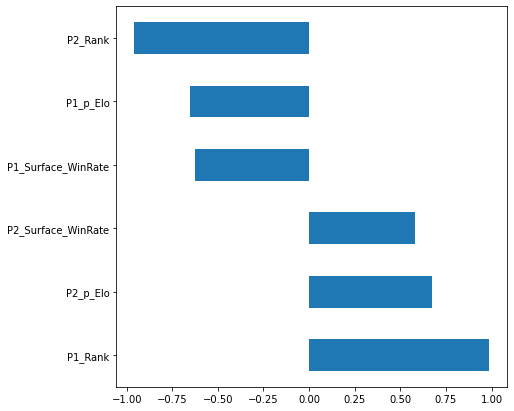

In [31]:
# Weights

plt.figure(figsize=(7,7))

pd.Series(clf.coef_[0], X_train.columns).sort_values(ascending=False).plot(kind='barh');

In [32]:
from sklearn import svm

clf = svm.SVC(random_state=10)
clf.fit(X_train_scaled, y_train) 
y_pred = clf.predict(X_test) 
cm = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
print(cm)
print('\n''Score:',clf.score(X_test, y_test))
print('\n',classification_report(y_test, y_pred))

Classe prédite    1     2
Classe réelle            
1               987   598
2               500  1078

Score: 0.6528612077141954

               precision    recall  f1-score   support

           1       0.66      0.62      0.64      1585
           2       0.64      0.68      0.66      1578

    accuracy                           0.65      3163
   macro avg       0.65      0.65      0.65      3163
weighted avg       0.65      0.65      0.65      3163



In [33]:
from sklearn import ensemble

clf = ensemble.RandomForestClassifier(n_jobs = -1, random_state = 10)
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test)
cm = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
print(cm)
print('\n''Score:',clf.score(X_test, y_test))
print('\n',classification_report(y_test, y_pred))

Classe prédite    1     2
Classe réelle            
1               961   624
2               548  1030

Score: 0.6294656971229845

               precision    recall  f1-score   support

           1       0.64      0.61      0.62      1585
           2       0.62      0.65      0.64      1578

    accuracy                           0.63      3163
   macro avg       0.63      0.63      0.63      3163
weighted avg       0.63      0.63      0.63      3163



In [34]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(criterion="entropy",max_depth=3,random_state=10)
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test)
cm = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
print(cm)
print('\n''Score:',clf.score(X_test, y_test))
print('\n',classification_report(y_test, y_pred))

Classe prédite    1     2
Classe réelle            
1               748   837
2               317  1261

Score: 0.6351564969965223

               precision    recall  f1-score   support

           1       0.70      0.47      0.56      1585
           2       0.60      0.80      0.69      1578

    accuracy                           0.64      3163
   macro avg       0.65      0.64      0.63      3163
weighted avg       0.65      0.64      0.63      3163



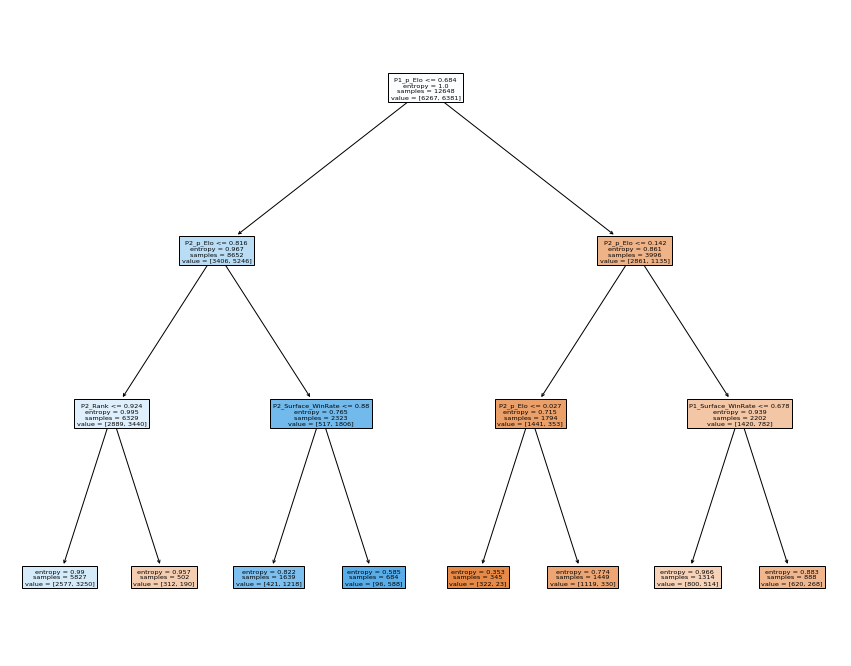

In [35]:
# Decision Tree - Features importance

from sklearn.tree import plot_tree

plt.figure(figsize=(15,12))
plot_tree(clf, feature_names = X_train.columns.tolist(), filled=True); #proportion=True

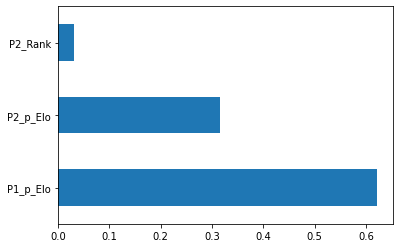

In [36]:
# 3 main features

feat_importances = pd.Series(clf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(3).plot(kind = 'barh');

In [37]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Model training

clf = LinearDiscriminantAnalysis()
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test)
cm = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
print(cm)
print('\n''Score:',clf.score(X_test, y_test))
print('\n',classification_report(y_test, y_pred))

Classe prédite     1     2
Classe réelle             
1               1010   575
2                533  1045

Score: 0.6496996522288966

               precision    recall  f1-score   support

           1       0.65      0.64      0.65      1585
           2       0.65      0.66      0.65      1578

    accuracy                           0.65      3163
   macro avg       0.65      0.65      0.65      3163
weighted avg       0.65      0.65      0.65      3163



In [38]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

clf = QuadraticDiscriminantAnalysis()
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test)
cm = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
print(cm)
print('\n''Score:',clf.score(X_test, y_test))
print('\n',classification_report(y_test, y_pred))

Classe prédite     1    2
Classe réelle            
1               1154  431
2                870  708

Score: 0.5886816313626304

               precision    recall  f1-score   support

           1       0.57      0.73      0.64      1585
           2       0.62      0.45      0.52      1578

    accuracy                           0.59      3163
   macro avg       0.60      0.59      0.58      3163
weighted avg       0.60      0.59      0.58      3163



/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [39]:
from lightgbm.sklearn import LGBMClassifier

clf = LGBMClassifier()
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test)
cm = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
print(cm)
print('\n''Score:',clf.score(X_test, y_test))
print('\n',classification_report(y_test, y_pred))

Classe prédite    1     2
Classe réelle            
1               977   608
2               536  1042

Score: 0.638318052481821

               precision    recall  f1-score   support

           1       0.65      0.62      0.63      1585
           2       0.63      0.66      0.65      1578

    accuracy                           0.64      3163
   macro avg       0.64      0.64      0.64      3163
weighted avg       0.64      0.64      0.64      3163



From the above tests, we can deduct that the Logistic Regression, SVM and Linear Discriminant Analaysis are the best performing models and we will focus on those in the following section.

## **Best models tuning**

### LOGISTIC REGRESSION OPTIMIZATION

In [40]:

from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [41]:
X_train,X_test,y_train,y_test=train_test_split(DATA,TARGET,test_size=0.2,random_state=10)

scaler = QuantileTransformer()  # Normalization
selector = SelectKBest()   # Best features selection
lr = LogisticRegression()               

pipe = Pipeline([ ('scaling', scaler), 
                 ('selection', selector),      
                 ('model', lr)])           

param_grid = {
    'selection__k' : [1, 2, 3, 4, 5, 'all'],  
    'model__solver' : ['lbfgs', 'liblinear'], 
    'model__C': [10**(i) for i in range(-4,3)]    
}

grid = GridSearchCV(estimator = pipe, param_grid = param_grid, cv = 3, iid = True) # GridSearchCV instantiation

grid.fit(X_train,y_train)  

print(grid.best_params_) # Best parameters
print(grid.best_score_) # Best cross validation score

# Model assessment

y_pred = grid.predict(X_test)

# Confusion Matrix 

cm = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
print(cm)

# Score

print('\n''Score:',grid.score(X_test, y_test))

#Classification report

print('\n',classification_report(y_test, y_pred))

{'model__C': 0.1, 'model__solver': 'lbfgs', 'selection__k': 'all'}
0.6590765338393422
Classe prédite     1     2
Classe réelle             
1               1008   577
2                530  1048

Score: 0.6500158077774265

               precision    recall  f1-score   support

           1       0.66      0.64      0.65      1585
           2       0.64      0.66      0.65      1578

    accuracy                           0.65      3163
   macro avg       0.65      0.65      0.65      3163
weighted avg       0.65      0.65      0.65      3163



/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


### SVC OPTIMIZATION

In [42]:
X_train,X_test,y_train,y_test=train_test_split(DATA,TARGET,test_size=0.2,random_state=10)

scaler = QuantileTransformer()  # Normalization
SVM = svm.SVC()             

pipe = Pipeline([ ('scaling', scaler),    
                 ('model', SVM)])           

param_grid = {
    'model__kernel' : ['rbf', 'linear'], 
    'model__C': [10**(i) for i in range(-2,2)]   
}

grid = GridSearchCV(estimator = pipe, param_grid = param_grid, cv = 3, iid = True) # GridSearchCV instantiation

grid.fit(X_train,y_train)  

print(grid.best_params_) # Best parameters
print(grid.best_score_) # Best cross validation score

# Model assessment

y_pred = grid.predict(X_test)

# Confusion Matrix 

cm = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
print(cm)

# Score

print('\n''Score:',grid.score(X_test, y_test))

#Classification report

print('\n',classification_report(y_test, y_pred))

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


{'model__C': 10, 'model__kernel': 'rbf'}
0.6632669196710942
Classe prédite    1     2
Classe réelle            
1               990   595
2               514  1064

Score: 0.6493834966803668

               precision    recall  f1-score   support

           1       0.66      0.62      0.64      1585
           2       0.64      0.67      0.66      1578

    accuracy                           0.65      3163
   macro avg       0.65      0.65      0.65      3163
weighted avg       0.65      0.65      0.65      3163



### LINEAR DISCRIMINANT ANALYSIS OPTIMISATION

In [43]:
X_train,X_test,y_train,y_test=train_test_split(DATA,TARGET,test_size=0.2,random_state=10)

scaler = QuantileTransformer()  # Normalization
selector = SelectKBest()   # Best features selection
ld = LinearDiscriminantAnalysis()            

pipe = Pipeline([ ('scaling', scaler), 
                 ('selection', selector),      
                 ('model', ld)])           

param_grid = {
    'selection__k' : [4, 5, 'all'],  
    'model__solver' : ['svd', 'lsqr', 'eigen']   
}

grid = GridSearchCV(estimator = pipe, param_grid = param_grid, cv = 3, iid = True) # GridSearchCV instantiation

grid.fit(X_train,y_train)  

print(grid.best_params_) # Best parameters
print(grid.best_score_) # Best cross validation score

# Model assessment

y_pred = grid.predict(X_test)

# Confusion Matrix 

cm = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
print(cm)

# Score

print('\n''Score:',grid.score(X_test, y_test))

#Classification report

print('\n',classification_report(y_test, y_pred))

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
numpy.linalg.LinAlgError: the leading minor of order 2 of 'b' is not positive definite. The factorization of 'b' could not be completed and no eigenvalues or eigenvectors were computed.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
numpy.linalg.LinAlgError: the leading minor of order 2 of 'b' is not positive definite. The factorization of 'b' could not be completed and no eigenvalues or eigenvectors were computed.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partitio

{'model__solver': 'svd', 'selection__k': 'all'}
0.6581277672359266
Classe prédite     1     2
Classe réelle             
1               1010   575
2                533  1045

Score: 0.6496996522288966

               precision    recall  f1-score   support

           1       0.65      0.64      0.65      1585
           2       0.65      0.66      0.65      1578

    accuracy                           0.65      3163
   macro avg       0.65      0.65      0.65      3163
weighted avg       0.65      0.65      0.65      3163



All 3 models have similar performances and the tuning doesn't provide a strong enhancement in the performance. In the following notebook we will focus on our ROI strategy and use the Logistic Regression as our preferred model for its combination of overall good performance and fast running time.